In [12]:
# Importing the libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

import xgboost as xgb
from sklearn.model_selection import train_test_split

from utils import *

In [13]:
# Importing the dataset
data = pd.read_csv("order_data.csv")
data.head()

,Date,TimeOfDay,MenuItem,Quantity
0,2023-01-01,07:00,Chicken Tikka Masala,2
1,2023-01-01,07:00,Shrimp Scampi,2
2,2023-01-01,07:00,Chicken Alfredo,3
3,2023-01-01,07:00,Caesar Salad,1
4,2023-01-01,07:00,Tiramisu,3


In [14]:
# Convert 'Date' column to numeric representation
data['Date'] = pd.to_datetime(data['Date'])
start_date = data['Date'].min()
data['NumericDate'] = (data['Date'] - start_date).dt.days + 1

In [15]:
# Extracting the hour from the 'TimeOfDay' column
def extract_hour(timestamp):
    time_obj = datetime.strptime(timestamp, '%H:%M')
    return time_obj.hour

# Applying the function to the 'TimeofDay' column to extract hours
data['TimeOfDay'] = data['TimeOfDay'].apply(extract_hour)

In [16]:
# Convert 'Date' column to datetime format and 'TimeOfDay' to timedelta format
data['DateTime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['TimeOfDay'], unit='h')

In [17]:
# Grouping the data by 'DateTime', 'Date', 'NumericDate', 'TimeOfDay' and 'MenuItem' columns
data = data.groupby(['DateTime', 'Date', 'NumericDate', 'TimeOfDay', 'MenuItem']).agg({'Quantity': 'sum'}).reset_index()
data.head(5)

,DateTime,Date,NumericDate,TimeOfDay,MenuItem,Quantity
0,2023-01-01 07:00:00,2023-01-01,1,7,Beef Stroganoff,5
1,2023-01-01 07:00:00,2023-01-01,1,7,Beef Tacos,4
2,2023-01-01 07:00:00,2023-01-01,1,7,Breakfast Combo,1
3,2023-01-01 07:00:00,2023-01-01,1,7,Caesar Salad,1
4,2023-01-01 07:00:00,2023-01-01,1,7,Chicken Alfredo,3


In [18]:
categorical_columns = ['MenuItem']
data = encodeLabels(data, categorical_columns)
print(data.head())

             DateTime       Date  NumericDate  TimeOfDay  MenuItem  Quantity
0 2023-01-01 07:00:00 2023-01-01            1          7         1         5
1 2023-01-01 07:00:00 2023-01-01            1          7         2         4
2 2023-01-01 07:00:00 2023-01-01            1          7         3         1
3 2023-01-01 07:00:00 2023-01-01            1          7         4         1
4 2023-01-01 07:00:00 2023-01-01            1          7         5         3


In [19]:
# Split the data into X and y
X_xgb = data.iloc[:, 2:-1].values
y_xgb = data.iloc[:, -1].values

# Split the data into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.4, random_state=42)

# Create XGBoost regressor and specify hyperparameters
model_xgb = xgb.XGBRegressor(
    n_estimators=100,  # Number of boosting rounds
    max_depth=3,       # Maximum depth of each tree
    learning_rate=0.1, # Learning rate
    random_state=0
)

# Train the model
model_xgb.fit(X_train_xgb, y_train_xgb)

# Make predictions on the test set
predictions_xgb = model_xgb.predict(X_test_xgb)

evaluate(model_xgb, predictions_xgb, X_test_xgb, y_test_xgb)

Model Performance
Score: 0.8495986599244272
Mean Squared Error (MSE): 8.493663321732035
Root Mean Squared Error (RMSE): 2.914389013452397
Mean Absolute Error (MAE): 2.2134085197024005
R-squared (R2): 0.8495986599244272


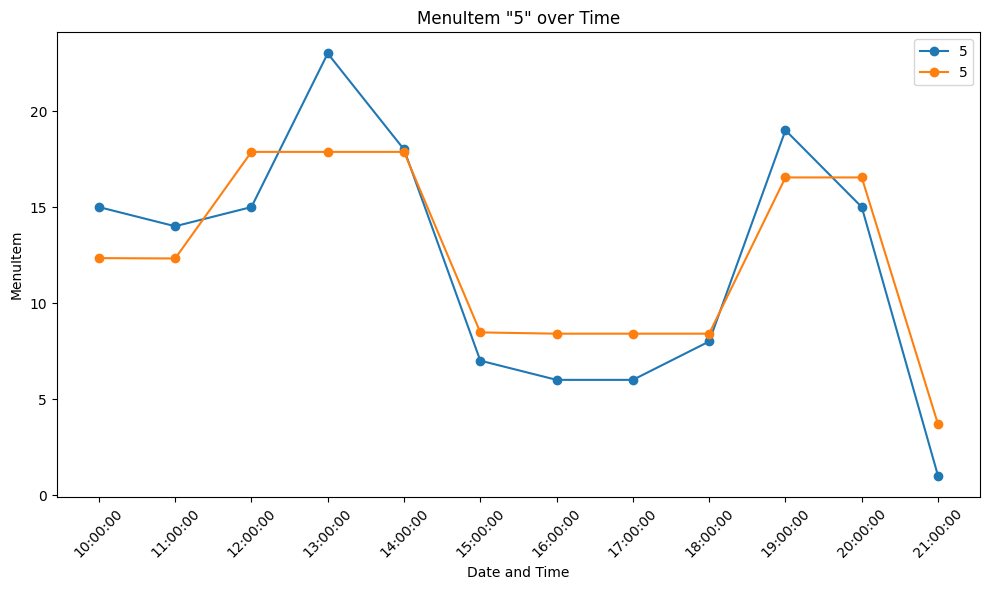

In [20]:
plot_predictions(model_xgb, data, '2023-07-20', 5)

### DecisionTreeRegressor 

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Assuming you have your data loaded into X and y variables

# Split the data into training and testing sets
X_train_dtr, X_test_dtr, y_train_dtr, y_test_dtr = train_test_split(X_xgb, y_xgb, test_size=0.4, random_state=42)

# Create the decision tree regressor and specify hyperparameters
model_dtr = DecisionTreeRegressor(max_depth=3, random_state=42)

# Train the model
model_dtr.fit(X_train_dtr, y_train_dtr)

# Make predictions on the test set
predictions_dtr = model_dtr.predict(X_test_dtr)

evaluate(model_dtr, predictions_dtr, X_test_dtr, y_test_dtr)


Model Performance
Score: 0.3767401411223933
Mean Squared Error (MSE): 35.19755475979558
Root Mean Squared Error (RMSE): 5.9327527135214035
Mean Absolute Error (MAE): 4.449427796038582
R-squared (R2): 0.3767401411223933


/Users/pramodsaji/miniconda/envs/tensorflow_metal/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


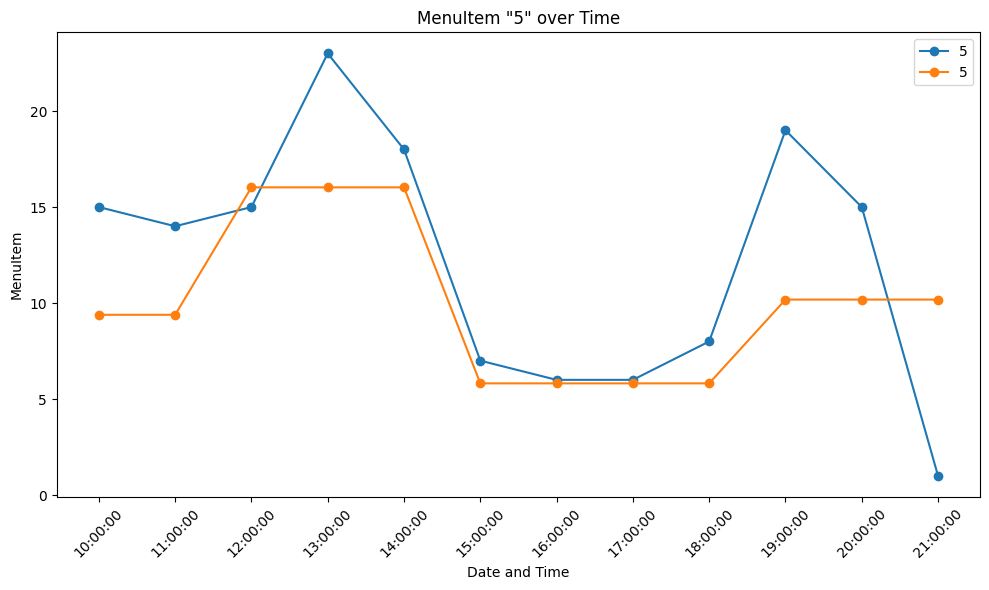

In [22]:
plot_predictions(model_dtr, data, '2023-07-20', 5)